В данном блокноте мы рассмотрим генерацию изображений с помощью генеративно-состязательных сетей (GAN). Такая сеть состоит из генератора, который обучен, что понятно и из названия, генерировать данные, и дискриминатора, который сравнивает смоделированные данные с реальными.

Начнем с простого примера, который не требует большого количества времени для получения результатов. Попробуем сгенерировать предмет одежды, взяв в качестве исходных изображений коллекцию Fashion MNIST.

Импортируем библиотеки (мы будем использовать библиотеку PyTorch):

In [1]:
import os
import numpy as np
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

"Зафиксируем случайность", чтобы наш эксперимент был воспроизводим.



In [2]:
torch.manual_seed(111)

Тензоры могут находиться либо на процессоре, либо на графическом процессоре. Время обучения на процессоре (CPU) дольше, поэтому, если есть возможность, поместим тензоры на графический процессор:



In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Определем функцию трансформации, которая преобразует данные в тензор PyTorch и нормализует их. В нашем примере этого достаточно, поскольку исходные изображения — это изображения в градациях серого, имеющие одинаковый размер.



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Загружаем датасет. В нашем случае набор данных FashionMNIST можно загрузить непосредственно через соответсвующую встроенную библиотеку.

Одновременно трансформируем исходные данные в тензоры и нормализуем. Стоит отметить , что в функции трансформации мы учли, что в нашем случае используется только один канал, так как изображения являются черно-белыми.

In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Создаем "загрузчик" данных, который будет "паковать" их в соответсвии с указанным размером.

In [8]:
batch_size = 32 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Выведем исходные изображения для первого пакета:



In [9]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0], cmap="gray_r")
    plt.show()

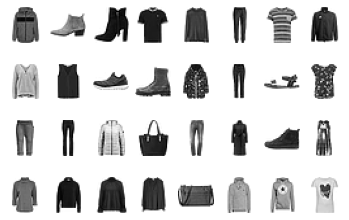

In [10]:
display_samples(next(iter(train_loader))[0], 4, 8)

Создаем дискриминатор, который получает выборку из реальных данных (или от генератора) и выдает вероятность того, что выборка относится к реальным обучающим данным.

В качестве архитектуры нейросети используется многослойный перцептрон. Его структура послойно задается с помощью nn.Sequential().

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),     # 28X28 =  784
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
        
discriminator = Discriminator().to(device=device)

In [12]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


Аналогично создаем класс генератора, наследуемый от nn.Module, определяем архитектуру нейронной сети, и, наконец, создаем экземпляр объекта Generator:

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [14]:
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


Определим количество эпох, скорость обучения. В качестве функции потерь выберем бинарную кросс-энтропию nn.BCELoss, а в качестве оптимизатора, стандартно, Adam.

In [26]:
lr = 0.0001
num_epochs = 0
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Нашей модели на обучение для 20 эпох подтребуется около часа (зависит от настроек среды выполнения).



In [27]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Р”Р°РЅРЅС‹Рµ РґР»СЏ С‚СЂРµРЅРёСЂРѕРІРєРё РґРёСЃРєСЂРёРјРёРЅР°С‚РѕСЂР°
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))
        # РћР±СѓС‡РµРЅРёРµ РґРёСЃРєСЂРёРјРёРЅР°С‚РѕСЂР°
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Р”Р°РЅРЅС‹Рµ РґР»СЏ РѕР±СѓС‡РµРЅРёСЏ РіРµРЅРµСЂР°С‚РѕСЂР°
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        

        # РћР±СѓС‡РµРЅРёРµ РіРµРЅРµСЂР°С‚РѕСЂР°
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # РџРѕРєР°Р·С‹РІР°РµРј loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
torch.save(generator, '/content/generator_20')
torch.save(discriminator, '/content/discriminator_20')

Генератор и дискриминатор сохранили на диске для возможности последующего использования.

Создадим тензор, заполненный произвольными числами, и сгенерируем на нем примеры нашей моделью:

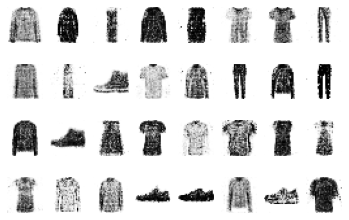

In [91]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
display_samples(generated_samples, 4, 8)

In [170]:
tensor = torch.load('/content/Comp_Vision_Task_6_Test_file_7.pt')
generator = torch.load("/content/generator_20")
generated_sample = generator(tensor).cpu().detach().numpy().reshape(28, 28)

In [171]:
generated_sample.min(), generated_sample.max()

(-1.0, 0.99633914)

In [175]:
# old_min, old_max = generated_sample.min(), generated_sample.max()
old_min, old_max = -1, 1
new_min, new_max = 0, 255
new_value = ( (generated_sample - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
new_value = new_value.round().astype(int)

In [179]:
new_value.mean()

72.12244897959184

In [ ]:
# right answer is 182.74362
# wtf?

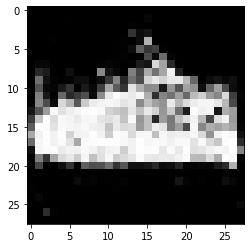

In [177]:
plt.imshow(new_value, cmap='gray')

Теперь рассмотрим другой пример — CycleGan. На входе у нас две коллекции — картины Оскара Моне и фотографии пейзажей. Мы хотим преобразовать фотографии в стиль картин Моне. В данном случае у нас непарные данные — картины и фотографии, несвязанные между собой.

В отличие от первой модели (GAN), сейчас мы будем генерировать изображение не из случайного шума, а из существующего изображения (фото пейзажа).

На обучение такой модели требуется достаточно много времени, поэтому мы воспользуемся предтренированной моделью и посмотрим, как она работает на новых данных.

Мы будем использовать подход, описанный в работе "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros. Предобученная модель выложена на https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.

Клонируем репозиторий:

In [107]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2508, done.
remote: Total 2508 (delta 0), reused 0 (delta 0), pack-reused 2508
Receiving objects: 100% (2508/2508), 8.19 MiB | 39.57 MiB/s, done.
Resolving deltas: 100% (1573/1573), done.


In [108]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [109]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.1 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408217 sha256=ec977ad70ce2ba0b45ac9f8b805adad59ea22cb613004da8d726f48c15b5da55
  Stored in directory: /root/.cache/pip/wheels/fb/b1/fc/b05c2c1930a412f01bd07dacaeb5fd8cc4bcccf71c835b0281

Загружаем коллекции:



In [110]:
!bash ./datasets/download_cyclegan_dataset.sh monet2photo

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./datasets/monet2photo/trainB/2016-03-31 05:58:36.jpg  
  inflating: ./datasets/monet2photo/trainB/2014-01-10 12:46:39.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-02-23 11:45:00.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-05-23 09:38:08.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-01-15 00:48:49.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-12-27 18:15:26.jpg  
  inflating: ./datasets/monet2photo/trainB/2017-01-02 11:16:05.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-08-06 11:08:32.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-12-16 07:43:36.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-03-25 12:57:28.jpg  
  inflating: ./datasets/monet2photo/trainB/2016-05-10 11:44:44.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-03-11 08:01:52.jpg  
  inflating: ./datasets/monet2photo/trainB/2015-08-30 05:26:05.jpg  
  inflating: ./datasets/monet2photo

Загружаем уже натренированную модель:



In [114]:
!bash ./scripts/download_cyclegan_model.sh style_monet

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [style_monet]
for details.

--2023-02-16 19:09:02--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/style_monet.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/style_monet_pretrained/latest_net_G.pth’

./checkpoints/style 100%[===================>]  43.46M  11.3MB/s    in 5.5s    

2023-02-16 19:09:07 (7.88 MB/s) - ‘./checkpoints/style_monet_pretrained/latest_net_G.pth’ saved [45575747/45575747]



Коллекции, которые использовались для обучения модели, находятся в папке /content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/. Добавим туда свою папку /testC/ с новыми фото, на которым мы посмотрим результаты работы модели.

In [118]:
os.makedirs('/content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC', exist_ok=True)

Тестируем модель:



In [122]:
!python test.py --dataroot '/content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC' --name style_monet_pretrained --model test  --no_dropout

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/datasets/monet2photo/testC	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_i

Смотрим на полученные результаты, которые находятся в папке /content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ и имеют соответсвующие названия "fake" и "real".

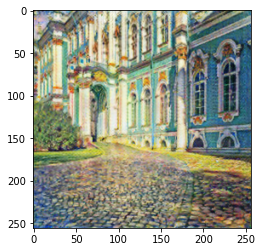

In [126]:
import matplotlib.pyplot as plt
import cv2
img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ITMO_1_fake.png')
img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/hermitage_fake.png')
plt.imshow(img)

In [127]:
img = cv2.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/hermitage_fake.png')

In [129]:
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [131]:
im_rgb.mean()

132.71870930989584

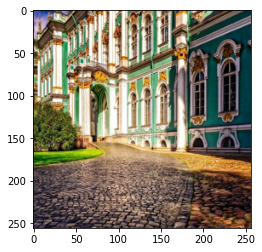

In [125]:
img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/ITMO_1_real.png')
img = plt.imread('/content/pytorch-CycleGAN-and-pix2pix/results/style_monet_pretrained/test_latest/images/hermitage_real.png')
plt.imshow(img)